# The Correlation Eliminator Algorithm
This notebook defines the correlation_eliminator function and its subsidiary functions, and applies it to some example data. The correlation_eliminator is explained in an accompanying pdf. However, I provide a brief summary here.

The correlation_eliminator function finds the least number of variables that must be eliminated from
a dataframe such that no two variables are absolutely correlated above a specified cutoff. This is an application of the more general problem (which I refer to as 'the problem') of how to eliminate the fewest number of points such that a reflexive, symmetric, but not transative, relationship between these points becomes only reflexive, whatever the arrangement of these points and the relationship between them (which I refer to as the 'state' or 'state of play').

The correlation_eliminator algorithm solves this problem by identifying some points that are optimal to remove until it can no longer do so, then bifurcates its potential solutions into two branches, one of which must contain only points that are optimal to remove in order to solve the problem. It identifies optimal points to remove within these two branches, and then bifurcates again if it can no longer do so. It repeats this until it identifies a branch that solves the problem and is the shortest of the current branches, since this branch must be the optimal set of points to remove in order to solve the problem.

*** Update ***
I had to cut down the data file size so I removed a lot of data. Your run will therefore look a different

In [1]:
import pandas as pd
import time
from datetime import date
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
# Be aware that I use a dark them so you may wish to remove this style if you do not.
from jupyterthemes import jtplot
jtplot.style('chesterish')

In [41]:
def myround(x, base=5):
    'Rounds to the nearest 5'
    return base * round(x/base)

def drop_false(series):
    '''
    This function takes a series and drops any indices with False boolean values.
    '''
    return series.apply(lambda x: x if x else np.nan).dropna()

def supermin(iterable):
    '''
    A more robust minimum function that returns the minimum of empty iterables as -1.
    '''
    if len(iterable) > 0:
        return min(iterable)
    else:
        return -1

def optimal_drops(state):
    '''
    Optimal drops takes a given state of connected points and applies the congruence rule and the proper
    subset rule once.
    '''
    # I find any points that satisfy the proper subset rule.
    subset_drops = list(state[state.apply(
        lambda y: sum(state.apply(lambda x: x.issubset(y) and x != y)) > 0)].index)

    # same_tuples returns a series which, for each node, gives which nodes have the same connections. 
    # I return the results in tuples because tuples are hashable, which means I can apply set() to 
    # return unique nodes.
    same_tuples = state.apply(lambda x: tuple(drop_false(state == x).index))

    # LOL returns a set of tuples of nodes to drop; i.e. all but one node from each group of 
    # equivalent nodes, from those groups of nodes with more than one member.
    LOL = set(same_tuples[same_tuples.apply(lambda x: len(x)) > 1].apply(lambda x: x[1:]))

    # same_drops then flattens this set of lists into a single list. 
    same_drops = [node for l in LOL for node in l]

    # Aggregating and appending the items to be dropped.
    drops = list(set(subset_drops + same_drops))

    return drops
    
def optimal_drops_loop(state):
    '''
    This function runs optimal_drops in a loop until no more optimal drops can be found, and returns
    an aggregated list of optimal drops.
    '''
    
    subtree_drops = []
    updating_state = state
    drops = ['dont ignore the while loop']
    while len(drops) > 0:
        
        drops = optimal_drops(updating_state)
        
        # I update the state of play by dropping the drops identified by optimal_drops and removing
        # them from the corresponding variable sets.
        updating_state = updating_state.drop(drops).apply(lambda x: x.difference(set(drops)))
        
        subtree_drops = subtree_drops + drops
        
    return subtree_drops

def fork(state,opsets,checklist):
    '''
    This function takes the current potential optimal set branches and bifurcates them each into two
    sub-branches in such a way as that, if the original branch was a subset of an optimal set, then
    one of the sub-branches must be also.
    '''
    assert len(opsets) == len(checklist), "checklist and opsets are not the same length"
    # next_sets will contain the new bifurcated sub-branches.
    next_sets = []
    # I run a for loop on every current branch, and will bifurcate each within this loop.
    for opset in opsets:
        # I ignore those that have already solved the problem.
        if checklist[opsets.index(opset)]:
            pass
        else:
            # Otherwise I calculate the state of play with the current branch.
            rump = state.drop(opset).apply(lambda x: x.difference(set(opset)))

            # I identify the most connected point and the points that it is connected to, excluding
            # itself.
            grinch = rump.apply(lambda x: len(x)).idxmax()
            elf = rump[grinch].difference(grinch)
            
            # I evaluate the state of play by taking the greedy approach and by taking the opposite
            # approach where I drop every connected point aside from the most connected one.
            greed = rump.drop(grinch).apply(lambda x: x.difference({grinch}))
            altruism = rump.drop(elf).apply(lambda x: x.difference(elf))
            
            # I use optimal_drops_loop to identify the optimal points to drop given the two states
            # identified above. I also add in the points from the mother branch and the pivotal points
            # I decided to remove (grinch/elf)
            greedy_tree = optimal_drops_loop(greed) + opset + [grinch]
            altruistic_tree = optimal_drops_loop(altruism) + opset + list(elf)
            
            # I add these two new sub-branches to next_sets.
            next_sets = next_sets + [greedy_tree] + [altruistic_tree]
        
    # I then add back in the solved branches
    next_sets = next_sets + [opsets[i] for i in range(len(checklist)) if checklist[i]]
        
    return next_sets

def lazy_solution(state):
    '''
    lazy_solution solves the problem by finding optimal points to remove until it can no longer do so,
    then takes the greedy approach by eliminating the point with the most connections, and then finding
    more optimal points given this elimination, and then repeating until the problem is solved.
    '''

    lazy_drops = []
    # In this loop I continuously evaluate the state of play, so I can just use it as a condition to
    # regulate the while loop.
    while state.apply(lambda x: len(x)).max() > 1:
    
        # I identify the point with the most connections, re-evaluate the state of play without that
        # point and add the point to lazy_drops.
        max_drop = state.apply(lambda x: len(x)).idxmax()
        state = state.drop(max_drop).apply(lambda x: x.difference({max_drop}))
        lazy_drops.append(max_drop)
        # I use optimal_drops_loop to find optimal drops given I have taken a greedy step. I append these
        # drops to lazy_drops and re-evaluate the state of play.
        drops = optimal_drops_loop(state)
        lazy_drops += drops
        state = state.drop(drops).apply(lambda x: x.difference(set(drops)))

    return lazy_drops

def isolator(state,give_up=12):
    '''
    This function solves a problem as represented by the 'state' input, but gives up and employs
    the lazy_solution function if it reaches give_up branches. 
    '''
    # I start the algorithm by finding any optimal drops I can and updating the state of play, calling
    # the state with these first optimal drops removed 'first_rump'
    first_drops = optimal_drops_loop(state)
    first_rump = state.drop(first_drops).apply(lambda x: x.difference(set(first_drops)))
    
    # I check whether or not I have already solved the problem. If I have, then the condition inside
    # the list will be True. I have the boolean inside the list since I will have to check multiple
    # branches as the algorithm moves on, so I set up the initial infrastructure to be consistent with
    # this.
    checklist = [first_rump.apply(lambda x: len(x)).max() == 1]
    # However, if the condition actually is True then I can just exit now and return first_drops
    if checklist[0]:
        return first_drops
    # I pretend that the initial problem is represetned by first_rump (and add in first_drops later)
    # and therefore pretend that I have identified an empty optimal set to drop.
    optimal_sets = [[]]
    # The length of the optimal set identified so far is therefore zero.
    opset_length = [0]
    # I have reached no leaf node since my optimal set doesn't actually solve the problem, so I
    # leaf_lengths is empty. This allows the while loop conditions to be true and for the loop to run.
    leaf_lengths = []
    
    # The while loop will stop once the length of a solved leaf node (list of variables to drop) is the
    # minimum of all present branch solutions, or if there are so many branch potential solutions that
    # the user tells it to give up.
    while not (min(opset_length) == supermin(leaf_lengths) or len(checklist) >= give_up):
        # I use the corrent optimal_sets and the fork function to bifurcate each of the current optimal
        # sets. I then evaluate the length of these new sets
        optimal_sets = fork(first_rump,optimal_sets,checklist)
        opset_length = [len(opset) for opset in optimal_sets]
        
        # I check to see if any of the optimal sets solves the problems. I then get the lengths of only
        # those optimal sets that do solve the problem. Now I have everything needed to check to see
        # if I can stop the while loop, since I can check if I already have an optimal set that solves
        # the problem and is shorter than any other.
        checklist = [first_rump.drop(opset).apply(lambda x: x.difference(set(opset))).apply(
        lambda x: len(x)).max() == 1 for opset in optimal_sets]
        leaf_lengths = [opset_length[i] for i in range(len(checklist)) if checklist[i]]
        # I report on the progress of the algorithm
        print(f'Current Branches: {len(checklist)} | Leaf Nodes: {sum(checklist)} | Give Up: {give_up}')
        print('--------------------------------------------------------------------')
        print(f'Branches Minimum: {min(opset_length)} | Leaf Minimum: {supermin(leaf_lengths)}')
        print('--------------------------------------------------------------------')
        print('--------------------------------------------------------------------')
    # I check to see if the while loop gave up or not. If not, then it contains at least one optimal
    # set that is a leaf node, solves the problem, and is truly optimal.
    if len(checklist) < give_up or np.isnan(give_up):
        # I identify truly optimal sets as the shortest of the optimal sets (which given the nature of
        # the while loop must solve the problem)
        truly_optimal_sets = [opset for opset in optimal_sets if len(opset) == supermin(leaf_lengths)]
        # I then add back in the first_drops to these truly optimal sets to make these truly optimal sets
        # of the original problem.
        really_truly_optimal_sets = [first_drops + opset for opset in truly_optimal_sets]
        
        return really_truly_optimal_sets
        
    else:
        # Otherwise I complete the leftmost branch 
        second_rump = first_rump.drop(optimal_sets[0]).apply(lambda x: x.difference(set(optimal_sets[0])))
        # Otherwise I just use lazy_solution to get an approximate answer.
        return first_drops + optimal_sets[0] + lazy_solution(second_rump)
    
def correlation_eliminator(dataframe,correlation_cutoff,give_up=12,override_corr=None):
    '''
    This function is the full monty when it comes to your high correlation eliminating needs. It takes
    a raw dataframe and a correlation_cutoff value that specifies an unacceptable level of absolute
    correlation between any two variables. It specifies the fewest number of variables to remove so as to
    ensure that no pairwise absolute correlation above the specified level exists. The give_up value
    specifies how many branch solutions being evaluated at once should trigger giving up on achieving
    an optimal solution. A pre-calculated correlation matrix can be inputted in the override_corr
    argument to avoid calculating it from scratch, which takes a lot of time.
    '''
    if override_corr is None:
        # I make sure there are no purely nan columns and then calculate the correlation matrix
        nancols = drop_false(dataframe.isnull().sum() == len(dataframe)).index
        dataframe.drop(nancols,index=1)
        corr_matrix = dataframe.corr()
    else:
        corr_matrix = override_corr    
    
    # for each variable, I get a series indicating which other variables it is highly absolutely 
    # correlated with above correlation_cutoff.
    corr_sets = corr_matrix.apply(lambda x: x[abs(x) >= correlation_cutoff].index.tolist(),axis=1)
    # I retain only those indices which indicate correlation above 'correlation_cutoff' with more
    # than one variable (i.e. I retain only those indices that are correlated not just with themselves).
    # I also transform the elements of the series into sets rather than lists.
    corr_sets = corr_sets[corr_sets[corr_sets.apply(lambda x: len(x) > 1)].index]
    corr_sets = corr_sets.apply(lambda x: set(x))
    # Then I run isolator to work out the optimal sets of variables to drop to solve the problem.
    return isolator(corr_sets,give_up)

# Application to example data

In [18]:
# I load in some messy data.
df = pd.read_csv('messy_data.csv',index_col=0,
                          header=[0,1],infer_datetime_format=True,low_memory=False)

In [47]:
%%time
# I remove any columns that are purely nans and calculate the correlation matrix of this data.
nancols = drop_false(df.isnull().sum() == len(df)).index
corr_matrix = df.drop(nancols,axis=1).corr()

Wall time: 46 s


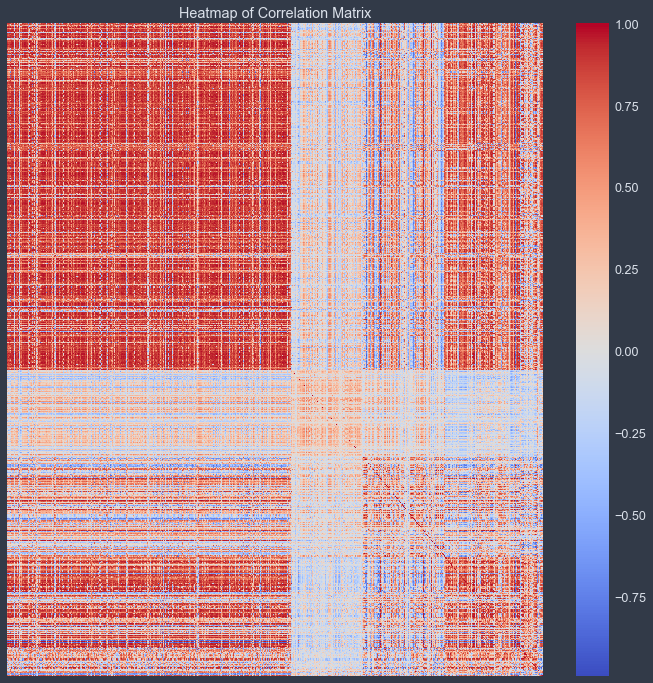

In [5]:
# Looking at a heatmap of the correlation matrix we can see just how simimlar the variables are.
plt.figure(figsize=(12,12))
sns.heatmap(corr_matrix,cmap='coolwarm',xticklabels=False,yticklabels=False)
plt.xlabel('')
plt.ylabel('')
plt.title('Heatmap of Correlation Matrix') ;

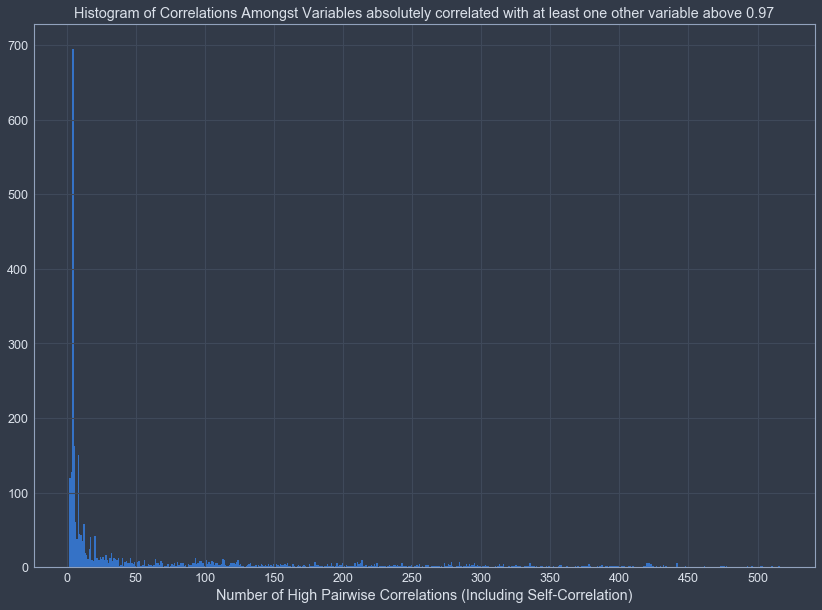

In [6]:
# Amongst those variables that are not highly correlated only with themselves, a histogram of the number
# of variables with which they are correlated above corr_cutoff is displayed here. 
corr_cutoff = 0.97
# I get the correlation matrix into a series/dictionary representation...
corr_pairs = corr_matrix.apply(lambda x: x[abs(x) > corr_cutoff].index.tolist(),axis=1)
# ...and then drop any variable that is only correlated with itself.
corr_pairs = corr_pairs.drop(corr_pairs[corr_pairs.apply(lambda x: len(x) == 1)].index)
# I use the remainder to make a histogram.
plt.figure(figsize=(14,10))
plt.title(f'Histogram of Correlations Amongst Variables absolutely correlated with at least one other variable above {corr_cutoff}')
plt.xlabel('Number of High Pairwise Correlations (Including Self-Correlation)')
corr_len = corr_pairs.apply(lambda x: len(x))
plt.xticks(np.arange(0,corr_len.max()+3,myround(corr_len.max()/10)))
corr_len.hist(bins = corr_len.max()) ;

In [7]:
%%time
# This cell runs the algorithm. It's a good idea to use the override_corr argument and input the pre 
# calculated correlation matrix.
sol = correlation_eliminator(df,corr_cutoff,give_up=48,override_corr=corr_matrix)

Current Branches: 2 | Leaf Nodes: 0 | Give Up: 48
--------------------------------------------------------------------
Branches Minimum: 9 | Leaf Minimum: -1
--------------------------------------------------------------------
--------------------------------------------------------------------
Current Branches: 4 | Leaf Nodes: 0 | Give Up: 48
--------------------------------------------------------------------
Branches Minimum: 12 | Leaf Minimum: -1
--------------------------------------------------------------------
--------------------------------------------------------------------
Current Branches: 8 | Leaf Nodes: 0 | Give Up: 48
--------------------------------------------------------------------
Branches Minimum: 25 | Leaf Minimum: -1
--------------------------------------------------------------------
--------------------------------------------------------------------
Current Branches: 16 | Leaf Nodes: 8 | Give Up: 48
-----------------------------------------------------------

In [46]:
# Using the same code from earlier but dropping the variables identified by the solution, then dropping
# every variable only highly correlated with itself, returns an empty series. This means that the
# problem has been solved.
corr_pairs = corr_matrix.drop(sol[0] + list(nancols)).drop(sol[0]+list(nancols),axis=1).apply(lambda x: x[abs(x) > corr_cutoff].index.tolist(),axis=1)
corr_pairs.drop(corr_pairs[corr_pairs.apply(lambda x: len(x) == 1)].index)

Series([], dtype: object)